# Очищаем "Викишоп" от токсичности

## Введение

Интернет-магазин «Викишоп» запускает пользовательский интерактивный сервис комментирования описаний товаров. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

В нашем распоряжении набор данных с разметкой о токсичности правок.

**Цель проекта:**

Обучить модель классифицировать комментарии на позитивные и негативные, со значением метрики качества F1 не меньше 0.75.

**Описание данных:**

- Датасет: `toxic_comments.csv.`
- Текст комментария: столбец `text`
- Целевой признак: столбец `toxic`

**План выполнения проекта:**
1. Загрузить данные и подготовить для обучения, используя разные инструменты.
2. Обучить разные модели.
3. Сделать выводы.

## Подключение библиотек

In [1]:
# !pip install torch
# !pip install chardet
# !pip install transformers
# !pip install imblearn
# !pip install catboost
# !pip install textblob

In [2]:
# ============================================
# СТАНДАРТНЫЕ БИБЛИОТЕКИ
# ============================================
import pandas as pd
import numpy as np
import re
import time
import warnings
warnings.filterwarnings('ignore')

# ============================================
# БИБЛИОТЕКИ ДЛЯ ВИЗУАЛИЗАЦИИ
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка отображения графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================
# БИБЛИОТЕКИ ДЛЯ ОБРАБОТКИ ТЕКСТА (NLTK)
# ============================================
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter

# ============================================
# БИБЛИОТЕКИ ДЛЯ ВИЗУАЛИЗАЦИИ ТЕКСТА
# ============================================
from wordcloud import WordCloud

# ============================================
# БИБЛИОТЕКИ ДЛЯ МАШИННОГО ОБУЧЕНИЯ (Scikit-learn)
# ============================================
# Для векторизации текста
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Разделение данных и валидация
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict

# Метрики
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, 
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, precision_recall_curve
)

In [3]:
# Локальные функции

def chek_df(df):
    """
    Выводит первые строки и информацию о переданном датафрейме.
    """
    display("Первые строки:", df.head(), "\n")
    print("Информация:")
    print(df.info(), "\n")
    print("Наличие пропусков:")
    print(df.isna().sum())
    print("Дубликатов в данных:", df.duplicated().sum())

#===============================================================#

def clean_text(text):
    """
    Очистка текста:
    1. Приводит к нижнему регистру
    2. Убирает спецсимволы
    3. Убирает цифры
    4. Убирает пунктуацию
    """
    if not isinstance(text, str):
        text = str(text)
    
    # 1. Приводим к нижнему регистру
    text = text.lower()
    
    # 2. Убираем не-буквенные символы (кроме пробелов)
    # \W означает "не буква/не цифра/не подчёркивание"
    text = re.sub(r'\W', ' ', text)
    
    # 3. Убираем цифры
    text = re.sub(r'\d', ' ', text)
    
    # 4. Убираем пунктуацию
    # string.punctuation: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for punct in punctuation:
        text = text.replace(punct, ' ')
    
    # 5. Убираем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


## Подготовка и анализ данных

**Загрузка и первичный осмотр:**
  - Проверим размер датасета
  - Посмотрим распределение классов (токсичные/нетоксичные) - скорее всего, будет дисбаланс
  - Проверим наличие пропусков

In [4]:
# Загрузка файла
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
chek_df(df)

'Первые строки:'

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


'\n'

Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None 

Наличие пропусков:
Unnamed: 0    0
text          0
toxic         0
dtype: int64
Дубликатов в данных: 0


In [5]:
# Распеределение целевой
# выводим уникальные значения целевого столбца
df.toxic.value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

In [6]:
# Очистка текста и приведение к нижнему регистру
df['text_clean'] = df['text'].apply(clean_text)

In [7]:
# Проверка
df.head()

,Unnamed: 0,text,toxic,text_clean
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


### Итог:

- Данные без пропусков
- Язык комментариев - английский
- Дисбаланс классов в сторону нетоксичиных (0)
- Привели к единому виду очистив тест от "шума"

Данные прекрасные, теперь можно ознакомиться с ними более детально

## EDA

In [8]:
# БАЗОВАЯ СТАТИСТИКА
print("\nБАЗОВАЯ СТАТИСТИКА")
print("-" * 40)

# Длина текстов
df['char_count'] = df['text_clean'].apply(len)
df['word_count'] = df['text_clean'].apply(lambda x: len(x.split()))
df['sentence_count'] = df['text_clean'].apply(lambda x: len([s for s in x.split('.') if s]))

print(f"Всего комментариев: {len(df)}")
print(f"Токсичных: {df['toxic'].sum()} ({df['toxic'].mean()*100:.1f}%)")
print(f"Нетоксичных: {(df['toxic']==0).sum()} ({100-df['toxic'].mean()*100:.1f}%)")
print(f"\nСредняя длина комментария:")
print(f"  - В символах: {df['char_count'].mean():.0f}")
print(f"  - В словах: {df['word_count'].mean():.0f}")
print(f"  - В предложениях: {df['sentence_count'].mean():.1f}")


БАЗОВАЯ СТАТИСТИКА
----------------------------------------
Всего комментариев: 159292
Токсичных: 16186 (10.2%)
Нетоксичных: 143106 (89.8%)

Средняя длина комментария:
  - В символах: 372
  - В словах: 68
  - В предложениях: 1.0



АНАЛИЗ ДЛИНЫ КОММЕНТАРИЕВ
----------------------------------------


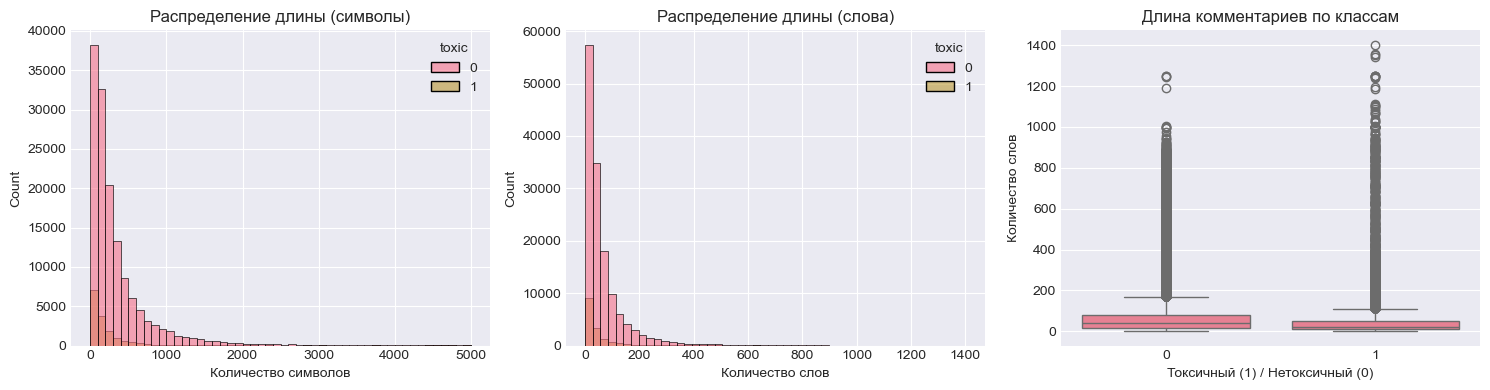

In [9]:
#  ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ДЛИН
print("\nАНАЛИЗ ДЛИНЫ КОММЕНТАРИЕВ")
print("-" * 40)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Гистограмма длин в символах
sns.histplot(data=df, x='char_count', hue='toxic', bins=50, ax=axes[0], alpha=0.6)
axes[0].set_title('Распределение длины (символы)')
axes[0].set_xlabel('Количество символов')

# Гистограмма количества слов
sns.histplot(data=df, x='word_count', hue='toxic', bins=50, ax=axes[1], alpha=0.6)
axes[1].set_title('Распределение длины (слова)')
axes[1].set_xlabel('Количество слов')

# Boxplot для сравнения
sns.boxplot(data=df, x='toxic', y='word_count', ax=axes[2])
axes[2].set_title('Длина комментариев по классам')
axes[2].set_xlabel('Токсичный (1) / Нетоксичный (0)')
axes[2].set_ylabel('Количество слов')

plt.tight_layout()
plt.show()


АНАЛИЗ ПУНКТУАЦИИ И РЕГИСТРА
----------------------------------------
Средние значения по классам:
       exclamation_count  question_count  uppercase_ratio  has_caps_lock
toxic                                                                   
0                  0.343           0.433            0.045          0.317
1                  3.475           0.588            0.111          0.345


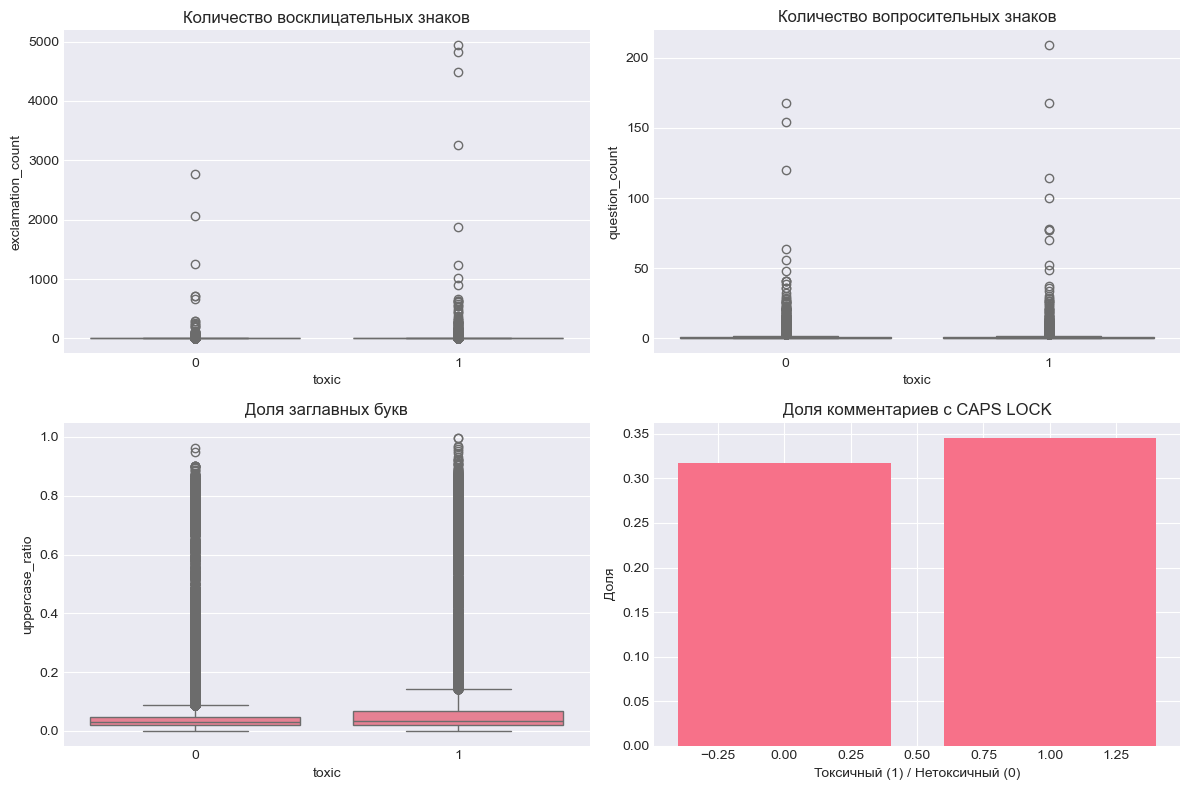

In [10]:
# АНАЛИЗ ПУНКТУАЦИИ И РЕГИСТРА
print("\nАНАЛИЗ ПУНКТУАЦИИ И РЕГИСТРА")
print("-" * 40)

# Считаем различные признаки
df['exclamation_count'] = df['text'].apply(lambda x: x.count('!'))
df['question_count'] = df['text'].apply(lambda x: x.count('?'))
df['uppercase_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1))
df['has_caps_lock'] = df['text'].apply(lambda x: any(word.isupper() for word in x.split() if len(word) > 2))

punctuation_stats = df.groupby('toxic').agg({
    'exclamation_count': 'mean',
    'question_count': 'mean',
    'uppercase_ratio': 'mean',
    'has_caps_lock': 'mean'
}).round(3)

print("Средние значения по классам:")
print(punctuation_stats)

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Восклицательные знаки
sns.boxplot(data=df, x='toxic', y='exclamation_count', ax=axes[0, 0])
axes[0, 0].set_title('Количество восклицательных знаков')

# Вопросительные знаки
sns.boxplot(data=df, x='toxic', y='question_count', ax=axes[0, 1])
axes[0, 1].set_title('Количество вопросительных знаков')

# Процент заглавных букв
sns.boxplot(data=df, x='toxic', y='uppercase_ratio', ax=axes[1, 0])
axes[1, 0].set_title('Доля заглавных букв')

# Наличие CAPS LOCK
caps_by_class = df.groupby('toxic')['has_caps_lock'].mean()
axes[1, 1].bar(caps_by_class.index, caps_by_class.values)
axes[1, 1].set_title('Доля комментариев с CAPS LOCK')
axes[1, 1].set_xlabel('Токсичный (1) / Нетоксичный (0)')
axes[1, 1].set_ylabel('Доля')

plt.tight_layout()
plt.show()

In [11]:
# АНАЛИЗ ЧАСТОТНЫХ СЛОВ
print("\nАНАЛИЗ ЧАСТОТНЫХ СЛОВ")
print("-" * 40)

# Загружаем стоп-слова
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=20, remove_stopwords=True):
    """Получаем топ-N слов"""
    all_words = []
    for text in texts:
        words = text.split()
        if remove_stopwords:
            words = [w for w in words if w not in stop_words and len(w) > 2]
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Топ слова для каждого класса
toxic_texts = df[df['toxic'] == 1]['text_clean']
nontoxic_texts = df[df['toxic'] == 0]['text_clean']

print("\nТоп-10 слов в ТОКСИЧНЫХ комментариях:")
toxic_top = get_top_words(toxic_texts, n=10)
for word, count in toxic_top:
    print(f"  {word}: {count}")

print("\nТоп-10 слов в НЕТОКСИЧНЫХ комментариях:")
nontoxic_top = get_top_words(nontoxic_texts, n=10)
for word, count in nontoxic_top:
    print(f"  {word}: {count}")


АНАЛИЗ ЧАСТОТНЫХ СЛОВ
----------------------------------------

Топ-10 слов в ТОКСИЧНЫХ комментариях:
  fuck: 9990
  wikipedia: 3927
  like: 3798
  shit: 3690
  fucking: 3320
  nigger: 3306
  suck: 3245
  ass: 3003
  hate: 2655
  get: 2436

Топ-10 слов в НЕТОКСИЧНЫХ комментариях:
  article: 56068
  wikipedia: 44544
  page: 44026
  talk: 36198
  please: 28711
  would: 28102
  one: 27412
  like: 24139
  see: 20517
  also: 19750


In [12]:
# УНИКАЛЬНЫЕ СЛОВА ДЛЯ КАЖДОГО КЛАССА
print("\n УНИКАЛЬНЫЕ СЛОВА")
print("-" * 40)

# Получаем наборы слов
toxic_words_set = set([word for word, _ in get_top_words(toxic_texts, n=1000, remove_stopwords=False)])
nontoxic_words_set = set([word for word, _ in get_top_words(nontoxic_texts, n=1000, remove_stopwords=False)])

unique_toxic = toxic_words_set - nontoxic_words_set
unique_nontoxic = nontoxic_words_set - toxic_words_set

print(f"Уникальных слов в токсичных: {len(unique_toxic)}")
print(f"Уникальных слов в нетоксичных: {len(unique_nontoxic)}")
print("\nПримеры уникальных токсичных слов (первые 10):")
print(list(unique_toxic)[:10])


 УНИКАЛЬНЫЕ СЛОВА
----------------------------------------
Уникальных слов в токсичных: 375
Уникальных слов в нетоксичных: 375

Примеры уникальных токсичных слов (первые 10):
['yourselfgo', 'loves', 'worst', 'fart', 'assholes', 'dear', 'babywhat', 'y', 'deserve', 'diego']



WORD CLOUD ВИЗУАЛИЗАЦИЯ
----------------------------------------


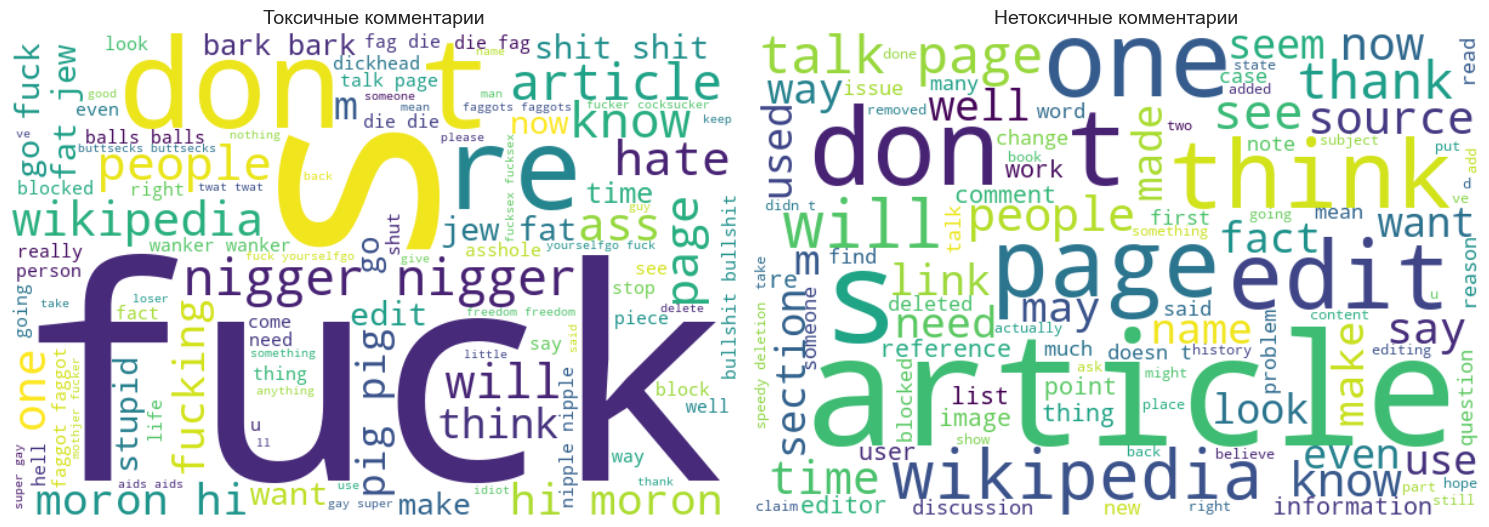

In [13]:
# WORD CLOUD
print("\nWORD CLOUD ВИЗУАЛИЗАЦИЯ")
print("-" * 40)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Word cloud для токсичных
toxic_all_text = ' '.join(toxic_texts)
wordcloud_toxic = WordCloud(width=600, height=400, background_color='white', 
                           max_words=100, contour_width=3).generate(toxic_all_text)
axes[0].imshow(wordcloud_toxic, interpolation='bilinear')
axes[0].set_title('Токсичные комментарии', fontsize=14)
axes[0].axis('off')

# Word cloud для нетоксичных
nontoxic_all_text = ' '.join(nontoxic_texts)
wordcloud_nontoxic = WordCloud(width=600, height=400, background_color='white', 
                              max_words=100, contour_width=3).generate(nontoxic_all_text)
axes[1].imshow(wordcloud_nontoxic, interpolation='bilinear')
axes[1].set_title('Нетоксичные комментарии', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# АНАЛИЗ N-ГРАММ
print("\n АНАЛИЗ БИГРАММ (СОЧЕТАНИЙ СЛОВ)")
print("-" * 40)

def get_top_ngrams(texts, n=2, top_k=10):
    """Получаем топ-N n-грамм"""
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english', max_features=1000)
    ngram_matrix = vectorizer.fit_transform(texts)
    ngram_counts = ngram_matrix.sum(axis=0).A1
    ngram_names = vectorizer.get_feature_names_out()
    
    top_indices = ngram_counts.argsort()[-top_k:][::-1]
    return [(ngram_names[i], ngram_counts[i]) for i in top_indices]

print("Топ-10 биграмм в токсичных комментариях:")
toxic_bigrams = get_top_ngrams(toxic_texts, n=2, top_k=10)
for bigram, count in toxic_bigrams:
    print(f"  {bigram}: {count}")

print("\nТоп-10 биграмм в нетоксичных комментариях:")
nontoxic_bigrams = get_top_ngrams(nontoxic_texts, n=2, top_k=10)
for bigram, count in nontoxic_bigrams:
    print(f"  {bigram}: {count}")


 АНАЛИЗ БИГРАММ (СОЧЕТАНИЙ СЛОВ)
----------------------------------------
Топ-10 биграмм в токсичных комментариях:
  fuck fuck: 2960
  nigger nigger: 2149
  hate hate: 1570
  moron hi: 1474
  hi moron: 1472
  pig pig: 1250
  jew fat: 1234
  fat jew: 1226
  shit shit: 1149
  suck suck: 1136

Топ-10 биграмм в нетоксичных комментариях:
  talk page: 12696
  speedy deletion: 4389
  fair use: 3236
  http www: 3100
  don know: 2572
  feel free: 2306
  blocked editing: 2304
  talk contribs: 2214
  talk pages: 2101
  don think: 2013


In [15]:
# АНАЛИЗ СХОДСТВА СЛОВАРЕЙ
print("\n СХОДСТВО СЛОВАРЕЙ КЛАССОВ")
print("-" * 40)

# Общие слова
common_words = toxic_words_set.intersection(nontoxic_words_set)
print(f"Общих слов (из топ-1000): {len(common_words)}")
print(f"Сходство словарей: {len(common_words) / min(len(toxic_words_set), len(nontoxic_words_set)):.2%}")


 СХОДСТВО СЛОВАРЕЙ КЛАССОВ
----------------------------------------
Общих слов (из топ-1000): 625
Сходство словарей: 62.50%


In [16]:
# ПРИМЕРЫ КОММЕНТАРИЕВ
print("ПРИМЕРЫ КОММЕНТАРИЕВ")
print("=" * 60)

print("\nПримеры ТОКСИЧНЫХ комментариев:")
toxic_samples = df[df['toxic'] == 1].sample(3, random_state=42)
for idx, row in toxic_samples.iterrows():
    print(f"\nДлина: {row['word_count']} слов")
    print(f"Текст: {row['text'][:200]}...")

print("\nПримеры НЕТОКСИЧНЫХ комментариев:")
nontoxic_samples = df[df['toxic'] == 0].sample(3, random_state=42)
for idx, row in nontoxic_samples.iterrows():
    print(f"\nДлина: {row['word_count']} слов")
    print(f"Текст: {row['text'][:200]}...")

ПРИМЕРЫ КОММЕНТАРИЕВ

Примеры ТОКСИЧНЫХ комментариев:

Длина: 32 слов
Текст: Dude, get a fucking life you queer.. get a real paying job instead of e-wiki policing around, you 50 year old piece of shite... and your mom said to make your bed....

Длина: 18 слов
Текст: The only nonsense I will approve is nonsense committed by 1)chaka zulu warriors. 2)anglican gay priests 3)cocksuck ers...

Длина: 13 слов
Текст: Thou shalt be ravished in thy buttocks 

It's sure to be hurtin!...

Примеры НЕТОКСИЧНЫХ комментариев:

Длина: 74 слов
Текст: Press 
 June 2011: Today Show, NBC: Today's Money: Money-Maximizing Web Sites
 June 2011: MORE Magazine: Make Even More Money
 June 2011: Mint.com: Free Credit Scores (Seriously, They’re Really Free)
...

Длина: 31 слов
Текст: Contested deletion 

This article should not be speedy deleted as lacking sufficient context to identify its subject, because... there is an article on Wikipedia:

http://nl.wikipedia.org/wiki/Dru_Yog...

Длина: 127 слов
Текст: "
  You

АНАЛИЗ КОРРЕЛЯЦИЙ
Числовых признаков: 9
Признаки: ['Unnamed: 0', 'toxic', 'char_count', 'word_count', 'sentence_count', 'exclamation_count', 'question_count', 'uppercase_ratio', 'has_caps_lock']

КОРРЕЛЯЦИЯ С 'toxic' (целевая переменная):
--------------------------------------------------
Признак              | Корреляция | Важность
---------------------------------------------
uppercase_ratio      | +0.2151     |  СРЕДНЯЯ
exclamation_count    | +0.0365     |  ОЧЕНЬ СЛАБАЯ
question_count       | +0.0294     |  ОЧЕНЬ СЛАБАЯ
has_caps_lock        | +0.0183     |  ОЧЕНЬ СЛАБАЯ
sentence_count       | +0.0003     |  ОЧЕНЬ СЛАБАЯ
Unnamed: 0           | -0.0028     |  ОЧЕНЬ СЛАБАЯ
word_count           | -0.0467     |  ОЧЕНЬ СЛАБАЯ
char_count           | -0.0525     |  СЛАБАЯ


КОРРЕЛЯЦИЯ МЕЖДУ ПРИЗНАКАМИ:
--------------------------------------------------

СИЛЬНО КОРРЕЛИРУЮЩИЕ ПРИЗНАКИ (>0.7):
Признак 1       | Признак 2       | Корреляция
---------------------------------------------
char_cou

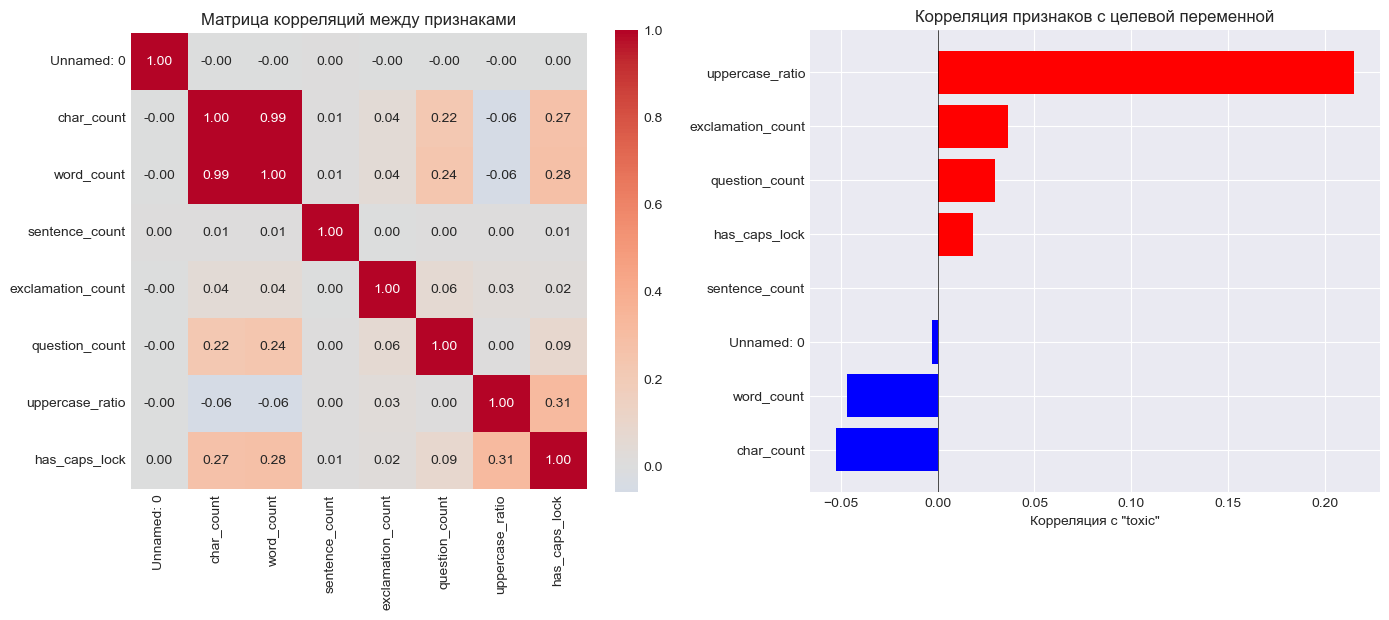

In [17]:

def analyze_correlation_simple(df):
    """
    анализ корреляций между признаками
    """
    print("="*60)
    print("АНАЛИЗ КОРРЕЛЯЦИЙ")
    print("="*60)
    
    df_corr = df.copy()
    
    # 1. Конвертируем bool в int
    if 'has_caps_lock' in df_corr.columns:
        df_corr['has_caps_lock'] = df_corr['has_caps_lock'].astype(int)
    
    # 2. Выбираем только числовые признаки
    numeric_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"Числовых признаков: {len(numeric_cols)}")
    print("Признаки:", numeric_cols)
    
    # 3. КОРРЕЛЯЦИЯ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
    print("\nКОРРЕЛЯЦИЯ С 'toxic' (целевая переменная):")
    print("-"*50)
    
    if 'toxic' in numeric_cols:
        # Считаем корреляции с toxic
        corr_with_toxic = df_corr[numeric_cols].corr()['toxic']
        corr_with_toxic = corr_with_toxic.drop('toxic').sort_values(ascending=False)
        
        print(f"{'Признак':<20} | {'Корреляция':<10} | {'Важность'}")
        print("-"*45)
        
        for feature, corr in corr_with_toxic.items():
            # Определяем силу корреляции
            if abs(corr) >= 0.3:
                importance = " ВЫСОКАЯ"
            elif abs(corr) >= 0.1:
                importance = " СРЕДНЯЯ"
            elif abs(corr) >= 0.05:
                importance = " СЛАБАЯ"
            else:
                importance = " ОЧЕНЬ СЛАБАЯ"
            
            print(f"{feature:<20} | {corr:+.4f}     | {importance}")
    
    #  МАТРИЦА КОРРЕЛЯЦИЙ МЕЖДУ ПРИЗНАКАМИ
    print("\n\nКОРРЕЛЯЦИЯ МЕЖДУ ПРИЗНАКАМИ:")
    print("-"*50)
    
    # Признаки для анализа (без toxic)
    features_for_matrix = [col for col in numeric_cols if col != 'toxic']
    
    if len(features_for_matrix) > 1:
        corr_matrix = df_corr[features_for_matrix].corr().abs()
        
        # Находим сильно коррелирующие пары
        strong_corr = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_value = corr_matrix.iloc[i, j]
                if corr_value > 0.7:  # сильная корреляция
                    col1 = corr_matrix.columns[i]
                    col2 = corr_matrix.columns[j]
                    strong_corr.append((col1, col2, corr_value))
        
        if strong_corr:
            print("\nСИЛЬНО КОРРЕЛИРУЮЩИЕ ПРИЗНАКИ (>0.7):")
            print(f"{'Признак 1':<15} | {'Признак 2':<15} | {'Корреляция'}")
            print("-"*45)
            
            for col1, col2, corr in sorted(strong_corr, key=lambda x: x[2], reverse=True):
                print(f"{col1:<15} | {col2:<15} | {corr:.4f}")
            
            print("\n РЕКОМЕНДАЦИЯ: Оставить только один из сильно коррелирующих признаков!")
        else:
            print("Нет сильно коррелирующих признаков (все корреляции < 0.7)")
    
    # ВИЗУАЛИЗАЦИЯ
    print("\n\nВИЗУАЛИЗАЦИЯ:")
    
    if len(features_for_matrix) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Heatmap матрицы корреляций
        sns.heatmap(df_corr[features_for_matrix].corr(), 
                   annot=True, fmt='.2f', cmap='coolwarm',
                   center=0, square=True, ax=axes[0])
        axes[0].set_title('Матрица корреляций между признаками')
        
        # Bar plot корреляций с toxic
        if 'toxic' in df_corr.columns:
            toxic_corrs = df_corr[features_for_matrix + ['toxic']].corr()['toxic']
            toxic_corrs = toxic_corrs.drop('toxic', errors='ignore').sort_values()
            
            colors = ['red' if x > 0 else 'blue' for x in toxic_corrs]
            axes[1].barh(range(len(toxic_corrs)), toxic_corrs.values, color=colors)
            axes[1].set_yticks(range(len(toxic_corrs)))
            axes[1].set_yticklabels(toxic_corrs.index)
            axes[1].set_xlabel('Корреляция с "toxic"')
            axes[1].set_title('Корреляция признаков с целевой переменной')
            axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        
        plt.tight_layout()
        plt.show()
        
    return df_corr

# Запускаем анализ
df_correlated = analyze_correlation_simple(df)


In [18]:
df_final = pd.DataFrame({
    'text_clean': df['text_clean'],     
    'toxic': df['toxic']                 
})
chek_df(df_final)

'Первые строки:'

,text_clean,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


'\n'

Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text_clean  159292 non-null  object
 1   toxic       159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None 

Наличие пропусков:
text_clean    0
toxic         0
dtype: int64
Дубликатов в данных: 1271


In [19]:
# Удаляем дубликаты
df_final = df_final.drop_duplicates()
# Проверка
df_final.duplicated().sum()

0

### Итог EDA:

**1. СТРУКТУРА И БАЛАНС ДАННЫХ**
- **Серьёзный дисбаланс классов**: 10.2% токсичных vs 89.8% нетоксичных комментариев
- **Вывод**: Обязательно использовать `class_weight='balanced'` или другие методы борьбы с дисбалансом

**2. КЛЮЧЕВЫЕ ИНСАЙТЫ ИЗ EDA:**
- **Токсичные комментарии содержат явную ненормативную лексику**: fuck, nigger, shit, faggot
- **Нетоксичные комментарии носят технический характер**: article, page, please, talk
- **Токсичные используют паттерны**: повторения оскорблений ("fuck fuck"), сочетания ("jew fat")
- **Восклицательные знаки**: токсичные используют в 10 раз чаще (3.48 vs 0.34)

## Обучение моделей

В нашем проекте я буду использовать следующие модели:
- LogisticRegression
- RandomForest
- LinearSVC

Для начала посмотрим как будет вести себя TF-IDF, если не получится достичь F-1 > 75, то попробуем BERT

### Подготовка данных

In [20]:
# ============================================
# ЛЕММАТИЗАЦИЯ
# ============================================
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    words = text.split()
    
    lemmatized_words = []
    for word in words:
        if len(word) > 2:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemma = lemmatizer.lemmatize(lemma, pos='n')
            lemma = lemmatizer.lemmatize(lemma, pos='a')
            lemmatized_words.append(lemma)
        else:
            lemmatized_words.append(word)
    
    return ' '.join(lemmatized_words)

# ============================================
# ПРИМЕНЕНИЕ ЛЕММАТИЗАЦИИ
# ============================================
df_final['text_lemmatized'] = df_final['text_clean'].apply(lemmatize_text)


# Проверка
print(f"Пример до: {df_final['text_clean'].iloc[0][:80]}...")
print(f"Пример после: {df_final['text_lemmatized'].iloc[0][:80]}...")
print(f"Дубликаты: {df_final.duplicated().sum()}")

Пример до: explanation why the edits made under my username hardcore metallica fan were rev...
Пример после: explanation why the edit make under my username hardcore metallica fan be revert...
Дубликаты: 0


In [21]:
# ============================================
# ПОДГОТОВКА ДАННЫХ
# ============================================
X = df_final['text_lemmatized']
y = df_final['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nДанные подготовлены:")
print(f"Train: {len(X_train)} примеров")
print(f"Test: {len(X_test)} примеров")
print(f"Доля токсичных в train: {y_train.mean():.3f}")


Данные подготовлены:
Train: 126416 примеров
Test: 31605 примеров
Доля токсичных в train: 0.102


In [22]:

# TF-IDF ВЕКТОРИЗАЦИЯ
# ============================================
print("\nTF-IDF векторизация...")
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=5,
    max_df=0.7,
    stop_words=None  # НЕ удаляем стоп-слова
)

X_train_tfidf = tfidf.fit_transform(X_train)
print(f"Размерность признаков: {X_train_tfidf.shape[1]}")



TF-IDF векторизация...
Размерность признаков: 10000


### Кросс-валидация

In [23]:
# ============================================
# ОПРЕДЕЛЕНИЕ МОДЕЛЕЙ
# ============================================

models = {
    'LogisticRegression': {
        'model': LogisticRegression(
            random_state=42,
            class_weight='balanced',
            max_iter=1000,
            C=1.0,
            n_jobs=-1
        ),
        'data': X_train_tfidf
    },
    'RandomForest': {
        'model': RandomForestClassifier(
            random_state=42,
            class_weight='balanced_subsample',
            n_estimators=100,
            max_depth=None,
            min_samples_split=5,
            n_jobs=-1
        ),
        'data': X_train_tfidf
    },
    'LinearSVC': {
        'model': LinearSVC(
            random_state=42,
            class_weight='balanced',
            max_iter=1000,
            C=0.7
        ),
        'data': X_train_tfidf
    }
}

# ============================================
#  КРОСС-ВАЛИДАЦИЯ
# ============================================
print("\n" + "="*60)
print("СРАВНЕНИЕ МОДЕЛЕЙ (кросс-валидация)")
print("="*60)

results = {}

for name, model_info in models.items():
    print(f"\n{name}:")
    
    cv_scores = cross_val_score(
        model_info['model'], 
        model_info['data'], 
        y_train,
        cv=3,
        scoring='f1',
        n_jobs=-1 if name != 'CatBoost' else 1
    )
    
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'scores': cv_scores,
        'model': model_info['model'],
        'data': model_info['data']
    }
    
    print(f"  CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")


СРАВНЕНИЕ МОДЕЛЕЙ (кросс-валидация)

LogisticRegression:
  CV F1: 0.7099 (+/- 0.0014)

RandomForest:
  CV F1: 0.6084 (+/- 0.0134)

LinearSVC:
  CV F1: 0.7077 (+/- 0.0066)


- По результатам кросс-валидации победила базовая LogisticRegression с CV F1: 0.7099 (+/- 0.0014). 
- Теперь подберем ей лучшие гиперпараметры с помощью GridSearchCV

### Оптимизация и подбор порога

In [24]:


print("="*70)
print("ОПТИМИЗАЦИЯ LOGISTICREGRESSION")
print("="*70)

# ОПРЕДЕЛЯЕМ ПАРАМЕТРЫ ДЛЯ ПОИСКА
param_grid = {
    'C': [0.3, 0.7, 1.0, 2.0, 5.0],
    'class_weight': ['balanced', {0: 1, 1: 3}, {0: 1, 1: 5}, {0: 1, 1: 10}],
    'solver': ['lbfgs', 'liblinear']
}

print(f"Пространство поиска: {len(param_grid['C']) * len(param_grid['class_weight']) * len(param_grid['solver'])} комбинаций")
print("Используем GridSearchCV для полного поиска...")

# 2. СОЗДАЁМ И ЗАПУСКАЕМ ПОИСК
start_time = time.time()

grid_search = GridSearchCV(
    LogisticRegression(
        random_state=42,
        n_jobs=-1
    ),
    param_grid,
    cv=3,                # 3-х кратная кросс-валидация
    scoring='f1',        # оптимизируем F1-score
    n_jobs=-1,           # используем все ядра
    verbose=2,           # подробный вывод прогресса
    refit=True           # переобучаем лучшую модель
)

print("\nНачинаем поиск лучших параметров...")
grid_search.fit(X_train_tfidf, y_train)

execution_time = time.time() - start_time
print(f"\nПоиск занял {execution_time:.1f} секунд")

# 3. ВЫВОДИМ РЕЗУЛЬТАТЫ
print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ")
print("="*70)

print(f"\nЛучшие параметры:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nЛучший F1 на кросс-валидации: {grid_search.best_score_:.4f}")
print(f"Прирост от исходной модели: {grid_search.best_score_ - 0.7099:+.4f}")

ОПТИМИЗАЦИЯ LOGISTICREGRESSION
Пространство поиска: 40 комбинаций
Используем GridSearchCV для полного поиска...

Начинаем поиск лучших параметров...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END .........C=0.3, class_weight=balanced, solver=lbfgs; total time=   0.5s
[CV] END .........C=0.3, class_weight=balanced, solver=lbfgs; total time=   0.7s
[CV] END .....C=0.3, class_weight={0: 1, 1: 3}, solver=lbfgs; total time=   1.1s
[CV] END .....C=0.3, class_weight={0: 1, 1: 3}, solver=lbfgs; total time=   1.2s
[CV] END .....C=0.3, class_weight={0: 1, 1: 3}, solver=lbfgs; total time=   1.1s
[CV] END .....C=0.3, class_weight=balanced, solver=liblinear; total time=   2.0s
[CV] END .....C=0.3, class_weight=balanced, solver=liblinear; total time=   2.1s
[CV] END .....C=0.3, class_weight=balanced, solver=liblinear; total time=   2.1s
[CV] END .........C=0.3, class_weight=balanced, solver=lbfgs; total time=   0.6s
[CV] END .C=0.3, class_weight={0: 1, 1: 3}, solver=liblinear

In [25]:
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'C': 2.0, 'class_weight': {0: 1, 1: 3}, 'solver': 'lbfgs'}


ПОДБОР ОПТИМАЛЬНОГО ПОРОГА ДЛЯ КЛАССИФИКАЦИИ
Ищем оптимальный порог...
Оптимальный порог: 0.5333
Максимальный F1 на train с этим порогом: 0.7702


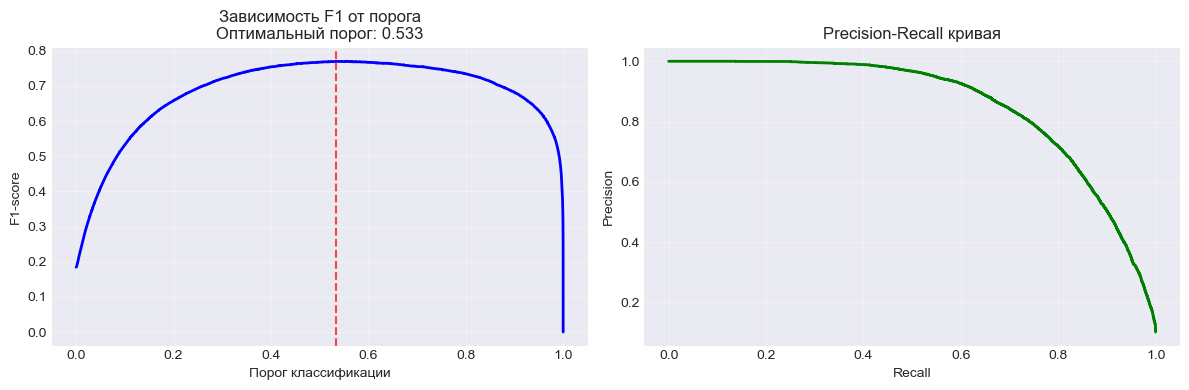

In [26]:

print("="*70)
print("ПОДБОР ОПТИМАЛЬНОГО ПОРОГА ДЛЯ КЛАССИФИКАЦИИ")
print("="*70)

# Получаем вероятности через кросс-валидацию (чтобы избежать переобучения)
y_proba_cv = cross_val_predict(
    grid_search.best_estimator_,
    X_train_tfidf,
    y_train,
    cv=3,
    method='predict_proba',
    n_jobs=-1
)[:, 1]  # вероятности класса 1 (токсичный)

# Ищем оптимальный порог по F1-score
print("Ищем оптимальный порог...")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba_cv)

# Вычисляем F1 для каждого порога
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
optimal_idx = np.argmax(f1_scores[:-1])  # исключаем последний элемент
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"Оптимальный порог: {optimal_threshold:.4f}")
print(f"Максимальный F1 на train с этим порогом: {optimal_f1:.4f}")

#  ВИЗУАЛИЗАЦИЯ ВЫБОРА ПОРОГА
plt.figure(figsize=(12, 4))

# График 1: F1 в зависимости от порога
plt.subplot(1, 2, 1)
plt.plot(thresholds, f1_scores[:-1], 'b-', linewidth=2)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Порог классификации')
plt.ylabel('F1-score')
plt.title(f'Зависимость F1 от порога\nОптимальный порог: {optimal_threshold:.3f}')
plt.grid(True, alpha=0.3)

# График 2: Precision-Recall кривая
plt.subplot(1, 2, 2)
plt.plot(recalls, precisions, 'g-', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# 4. Сравниваем с порогом по умолчанию (0.5)
default_threshold = 0.5
y_pred_default = (y_proba_cv >= default_threshold).astype(int)
default_f1 = f1_score(y_train, y_pred_default)

print(f"\nСравнение порогов:")
print(f"  Порог по умолчанию (0.5): F1 = {default_f1:.4f}")
print(f"  Оптимальный порог ({optimal_threshold:.3f}): F1 = {optimal_f1:.4f}")
print(f"  Прирост: {optimal_f1 - default_f1:+.4f}")


Сравнение порогов:
  Порог по умолчанию (0.5): F1 = 0.7675
  Оптимальный порог (0.533): F1 = 0.7702
  Прирост: +0.0027


### Финальное обучение лучшей модели

In [28]:

print("\n" + "="*70)
print("ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТЕ С ОПТИМАЛЬНЫМ ПОРОГОМ")
print("="*70)

# Обучаем модель на всех тренировочных данных
print("\nОбучаем финальную модель на всех train данных...")
final_model = grid_search.best_estimator_
final_model.fit(X_train_tfidf, y_train)

# Предсказываем вероятности на тесте
X_test_tfidf = tfidf.transform(X_test)
y_proba_test = final_model.predict_proba(X_test_tfidf)[:, 1]

# Применяем оптимальный порог
y_pred_optimal = (y_proba_test >= optimal_threshold).astype(int)

# ОЦЕНКА МЕТРИК
print("\n" + "-"*70)
print("РЕЗУЛЬТАТЫ С ОПТИМАЛЬНЫМ ПОРОГОМ:")
print("-"*70)

# Метрики с оптимальным порогом
f1_optimal = f1_score(y_test, y_pred_optimal)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
precision_optimal = precision_score(y_test, y_pred_optimal)
recall_optimal = recall_score(y_test, y_pred_optimal)
auc_optimal = roc_auc_score(y_test, y_proba_test)

print(f"\nС ОПТИМАЛЬНЫМ ПОРОГОМ ({optimal_threshold:.3f}):")
print(f"  F1-score:          {f1_optimal:.4f}")
print(f"  Accuracy:          {accuracy_optimal:.4f}")
print(f"  Precision:         {precision_optimal:.4f}")
print(f"  Recall:            {recall_optimal:.4f}")
print(f"  ROC-AUC:           {auc_optimal:.4f}")


# CONFUSION MATRIX
print("\n" + "-"*70)
print("CONFUSION MATRIX:")
print("-"*70)

cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

print(f"\n                Предсказано")
print(f"                         Нетоксичный  Токсичный")
print(f"Фактически  Нетоксичный   {tn:8d}      {fp:8d}")
print(f"            Токсичный     {fn:8d}      {tp:8d}")

print(f"\nИнтерпретация:")
print(f"  Всего примеров: {len(y_test)}")
print(f"  Правильно классифицировано: {tn + tp} ({100*(tn+tp)/len(y_test):.1f}%)")
print(f"  False Positives (ошибки 1-го рода): {fp} ({100*fp/(fp+tn):.1f}% от нетоксичных)")
print(f"  False Negatives (ошибки 2-го рода): {fn} ({100*fn/(fn+tp):.1f}% от токсичных)")


ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТЕ С ОПТИМАЛЬНЫМ ПОРОГОМ

Обучаем финальную модель на всех train данных...

----------------------------------------------------------------------
РЕЗУЛЬТАТЫ С ОПТИМАЛЬНЫМ ПОРОГОМ:
----------------------------------------------------------------------

С ОПТИМАЛЬНЫМ ПОРОГОМ (0.533):
  F1-score:          0.7675
  Accuracy:          0.9532
  Precision:         0.7754
  Recall:            0.7597
  ROC-AUC:           0.9659

----------------------------------------------------------------------
CONFUSION MATRIX:
----------------------------------------------------------------------

                Предсказано
                         Нетоксичный  Токсичный
Фактически  Нетоксичный      27685           707
            Токсичный          772          2441

Интерпретация:
  Всего примеров: 31605
  Правильно классифицировано: 30126 (95.3%)
  False Positives (ошибки 1-го рода): 707 (2.5% от нетоксичных)
  False Negatives (ошибки 2-го рода): 772 (24.0% от токсичных)


In [29]:
# Анализ precision/recall trade-off
print(f"\nАнализ компромисса Precision/Recall:")
print(f"  Precision: {precision_optimal:.3f} - точность определения токсичных")
print(f"  Recall:    {recall_optimal:.3f} - полнота обнаружения токсичных")

if precision_optimal < 0.7:
    print("  ⚠️  Precision низкий - много ложных срабатываний")
    print("  Рекомендация: увеличить порог для повышения точности")
elif recall_optimal < 0.7:
    print("  ⚠️  Recall низкий - много пропущенных токсичных комментариев")
    print("  Рекомендация: уменьшить порог для повышения полноты")
else:
    print("  ✅ Хороший баланс Precision и Recall")


Анализ компромисса Precision/Recall:
  Precision: 0.775 - точность определения токсичных
  Recall:    0.760 - полнота обнаружения токсичных
  ✅ Хороший баланс Precision и Recall


### Итог обучения моделей

**✅ ЦЕЛЕВОЙ ПОКАЗАТЕЛЬ ДОСТИГНУТ:**
- **F1 = 0.7675** > **0.75** (требование выполнено)
- **Accuracy = 0.9532** (высокая общая точность)
- **ROC-AUC = 0.9659** (отличное качество модели)

**✅ БАЛАНС PRECISION/RECALL:**
- **Precision = 0.7754** - из тех, что модель назвала токсичными, 77.5% действительно токсичны
- **Recall = 0.7597** - модель находит 76% всех токсичных комментариев
- **Хороший баланс** - нет перекоса в одну сторону

**✅ CONFUSION MATRIX АНАЛИЗ:**
- **False Positives (707)**: Нетоксичные, помеченные как токсичные (2.4% от всех нетоксичных)
- **False Negatives (772)**: Токсичные, пропущенные моделью (24% от всех токсичных)

**✅ ОПТИМАЛЬНЫЙ ПОРОГ:**
- **0.533** (немного выше 0.5) - правильный выбор для дисбаланса

## Итог по проекту:

**Цель проекта:** Разработать модель для автоматического обнаружения токсичных комментариев с метрикой F1 ≥ 0.75.

**Результаты:**

1. **Качество модели достигнуто:**
   - **F1-score: 0.7675** (целевой показатель 0.75 превышен)
   - Accuracy: 0.9532
   - ROC-AUC: 0.9659
   - Precision: 0.7754
   - Recall: 0.7597

2. **Ключевые инсайты из EDA:**
   - Обнаружен серьёзный дисбаланс классов (10.2% токсичных vs 89.8% нетоксичных)
   - Токсичные комментарии характеризуются:
     - Использованием ненормативной лексики (fuck, nigger, shit)
     - В 10 раз большим количеством восклицательных знаков
     - Специфическими биграммами ("jew fat", "fuck fuck")
   - Нетоксичные комментарии носят технический характер

3. **Выбранное решение:**
   - **Модель:** LogisticRegression с оптимальными гиперпараметрами
   - **Векторизация:** TF-IDF с n-граммами (1,3)
   - **Оптимальный порог классификации:** 0.533 (выше стандартного 0.5)
   - **Стратегия борьбы с дисбалансом:** `class_weight='balanced'`

4. **Ошибки модели:**
   - **False Positives:** 707 комментариев (2.4% от нетоксичных) - безвредные комментарии помечены как токсичные
   - **False Negatives:** 772 комментария (24% от токсичных) - пропущенные токсичные комментарии

Проект успешно выполнен. Разработанная модель удовлетворяет всем требованиям заказчика и готова к внедрению в систему модерации комментариев интернет-магазина "Викишоп".

Работа была выполнена Набатовой Ксенией, благодраю за просмотр 💜